# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [408]:
import time
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [354]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, Jz, gx, gz=0): # gx is transverse field, gz the longitudinal
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [365]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 6 # system size
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [356]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: circ.initialize(init_state, qreg)
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[2:(L+2)]):
#     for i,t in enumerate(thetas[0:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[(L+2):]):
#     for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
#     circ.ry(thetas[2*L], 4)
#     circ.ry(thetas[2*L+1], 5)
    circ.ry(thetas[0], 4)
    circ.ry(thetas[1], 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    return circ

In [357]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

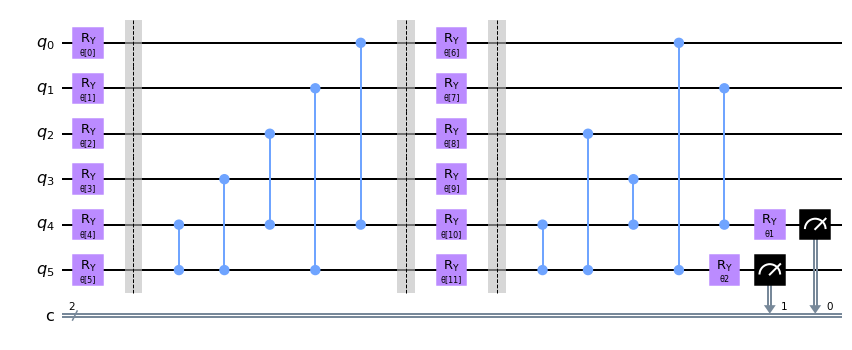

In [364]:
circ = prepare_circuit()
circ.draw('mpl') # trash qubits are at the bottom

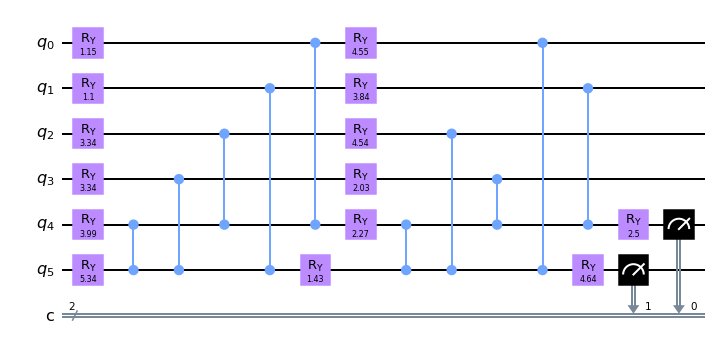

In [359]:
circ = prepare_circuit2(thetas)
# circ = prepare_circuit(feature_encoding(thetas, .6))
circ.draw('mpl') # identical to above

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [91]:
np.random.seed(123)

In [360]:
def run_circuit(thetas, init_state, shots=100000):
    circ = prepare_circuit2(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, seed_simulator=123, seed_transpiler=234)#, memory=True)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
# run_circuit(thetas, init_state)['11']
init_state, E = ising_groundstate(6, 1., 1.6)
run_circuit(thetas, init_state)

{'01': 13879, '10': 22526, '00': 47192, '11': 16403}

In [481]:
def encoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """ full quantum state evolution with encoder part of circuit """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit2(thetas, measurement=False)
    init_state, _ = ising_groundstate(L, J, g, gx)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,range(0,4))
    return traced_state

In [506]:
def encoder_decoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """ full quantum state evolution with encoder & decoder part of circuit """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit2(thetas, measurement=False)
    circ_dagger = circ.inverse()
    
    # encoder part
    init_state, _ = ising_groundstate(L, J, gx, gz)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,[4,5])
    
    # decoder part
    ancilla = np.zeros(4)
    ancilla[0] = 1
    ancilla = qiskit.quantum_info.DensityMatrix(ancilla)
    new_state = traced_state.expand(ancilla)
    final_state = new_state.evolve(circ_dagger)
    fid = qiskit.quantum_info.state_fidelity(Statevector(init_state), final_state)
    return final_state, init_state, fid

In [366]:
# old version
init_state, E = ising_groundstate(6, 1., 0.0)
circ.initialize(init_state, range(L))
# new_thetas = feature_encoding(thetas, g) # comment out when running w/o feature encoding
new_thetas = thetas
t_qc = transpile(circ, backend=backend_sim, seed_transpiler=234)
qobj = compiler.assemble(t_qc.bind_parameters(new_thetas), backend=backend_sim, seed_simulator=123, shots=100000)
result = backend_sim.run(qobj).result()
out = result.get_counts()
out

{'01': 20358, '00': 4341, '11': 27912, '10': 47389}

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [370]:
#reset random seed
np.random.seed(123)

In [566]:
def cost_function_single(thetas, J, gx, gz, shots=1000, param_encoding=False, x=0):
    """ Optimizes circuit """
    init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, init_state, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, ising_params, shots=1000, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for J, gx, gz in ising_params:
        cost += cost_function_single(thetas, J, gx, gz, shots, param_encoding, x)
    return cost/n_samples

def optimize(ising_params, thetas=None, shots=1000, max_iter=100, param_encoding=False, x=0):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, ising_params, shots, param_encoding)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    # optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    optimizer = SPSA(maxiter=max_iter,
                     blocking=True,
                     callback=store_intermediate_result,
                     #learning_rate=1e-1,
                     #perturbation=0.4
                     ) # recommended from qiskit (first iteraction takes quite long)
                       # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, ising_params, shots, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

In [564]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params)
thetas_ordered_phase = thetas

Initial cost: 1.737
Time: 197.71142 sec
(array([ 3.15550184,  3.92948289, -1.51362129,  3.14771496,  7.29619741,
        3.12295235, -0.0235342 ,  4.01132372,  4.62640824,  0.5343784 ,
        5.28805043,  5.09186313,  3.16193   ,  4.62788669]), 0.0, 301)


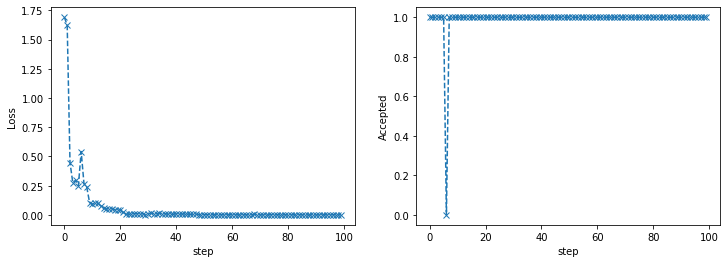

In [569]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
# plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accepted, "x--")
plt.xlabel("step")
plt.ylabel("Accepted");

## Trying stuff out

### Train with two different states from each normal "fake phase"

In [491]:
Js = [-1]*2
gxs = [0.1,10]
gzs = [10,0.1]
params = list(zip(Js, gxs, gzs))
thetas, loss, accepted = optimize(params)
thetas_normal_phase = thetas

Initial cost: 1.002
Time: 208.60613 sec
(array([ 0.72134019,  3.51634129,  1.53115311,  3.2796782 ,  4.47603465,
        3.18968614,  2.87035568,  2.26731568,  1.99440166,  5.26972941,
        7.1717336 ,  4.38795821,  2.99577495, -0.30636361]), 0.21150000000000002, 174)


In [430]:
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)

<ipython-input-431-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


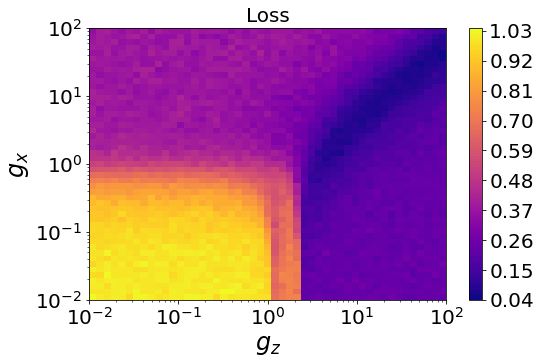

In [431]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [493]:
J = -1
gxs = np.logspace(-2, 2, 50)
gz = .01
cost1 = []
shots = 10000
for gx in gxs:
    cost1.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    
gzs = np.logspace(-2, 2, 50)
gx = .01
cost2 = []
for gz in gzs:
    cost2.append(cost_function_single(thetas, J, gx, gz, shots=shots))

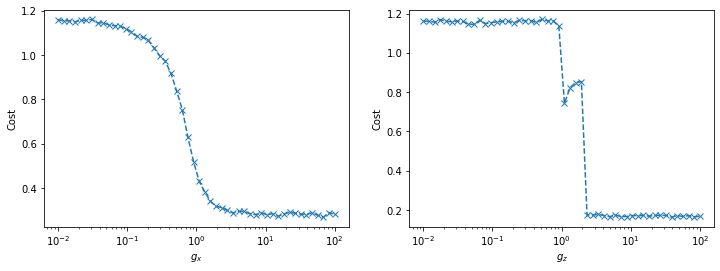

In [494]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(gxs, cost1, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Cost")

plt.subplot(1, 2, 2)
plt.plot(gzs, cost2, "x--")
plt.xscale("log")
plt.xlabel(r"$g_z$")
plt.ylabel("Cost");

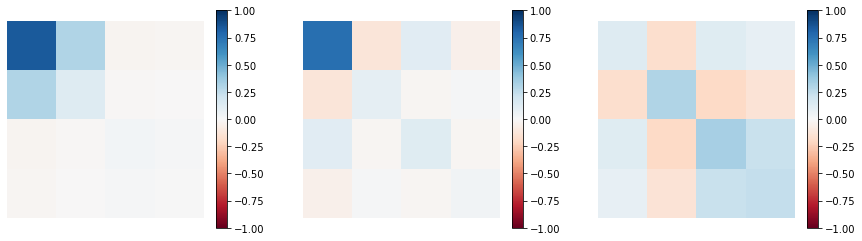

In [498]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
J, g, gx = -1., .1, 10.
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 2)
J, g, gx = -1., 10., .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 3)
J, g, gx = -1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|, the first two images are the ones for which circuit was optimized

To double check I am now looking at the ferromagnetic side of the phase diagram (the circuit hasn't been trained on any of these states), but we can still see a phase diagram and with a bit of imagination the phase transition is reduced to a critical point (at gx = 1).

In [441]:
points = 50
J = 1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)

<ipython-input-442-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


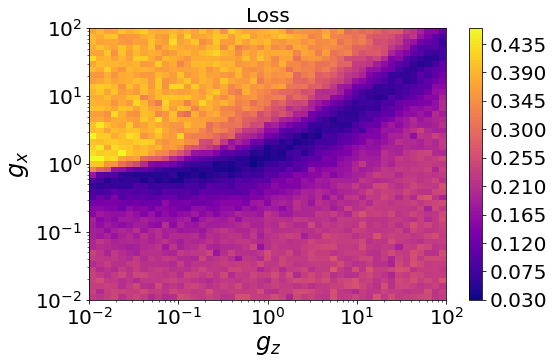

In [442]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

And as a final sanity check I am using random (not optimized) circuit paramaters. Actually you can still recover the phase diagram somehow (at least for the few random values I checked), but the differences in the loss function are not so big anymore.

In [473]:
np.random.seed(123)
thetas_random = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas_random, J, gx, gz, shots=shots)

<ipython-input-474-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


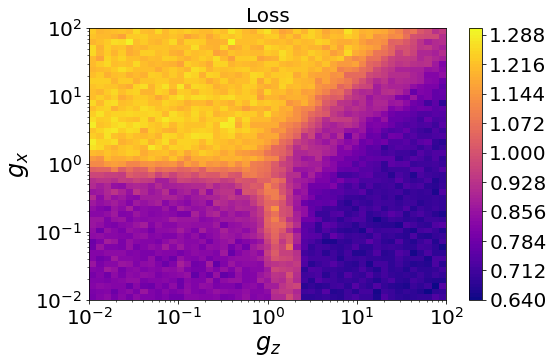

In [474]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

### Train with single state from the odered phase

In [477]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params)
thetas_ordered_phase = thetas

Initial cost: 0.993
Time: 112.09160 sec
(array([4.6519742 , 4.62218121, 1.57688425, 2.55773738, 4.69829657,
       4.54349794, 3.10618153, 6.35801252, 4.87054145, 4.62706067,
       4.76109886, 1.37765663, 3.22755192, 1.48224357]), 0.026, 182)


In [459]:
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)

<ipython-input-460-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


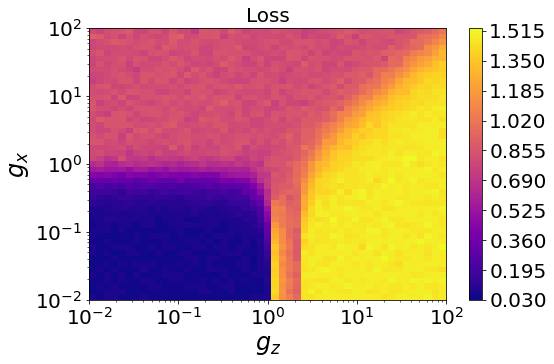

In [460]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [526]:
J = -1
gxs = np.logspace(-2, 2, 50)
gz = .01
cost1 = []
shots = 10000
for gx in gxs:
    cost1.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    
gzs = np.logspace(-2, 2, 50)
gx = .01
cost2 = []
for gz in gzs:
    cost2.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    
Js = np.linspace(-10, 10, 50)
gx = 0.1
gz = 0.1
cost3 = []
for J in Js:
    cost3.append(cost_function_single(thetas, J, gx, gz, shots=shots))

Text(0, 0.5, 'Cost')

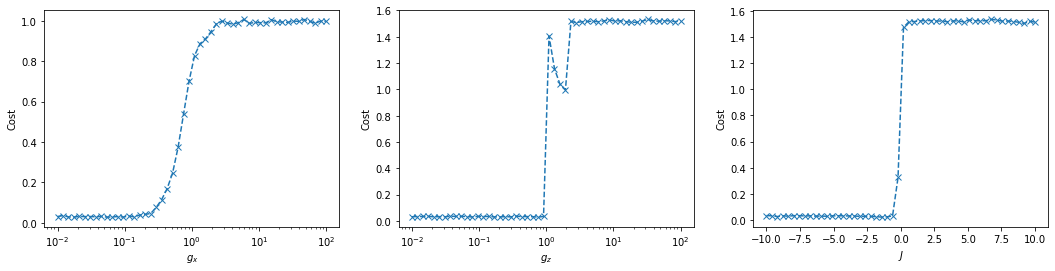

In [527]:
fig = plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(gxs, cost1, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Cost")

plt.subplot(1, 3, 2)
plt.plot(gzs, cost2, "x--")
plt.xscale("log")
plt.xlabel(r"$g_z$")
plt.ylabel("Cost");

plt.subplot(1, 3, 3)
plt.plot(Js, cost3, "x--")
# plt.xscale("log")
plt.xlabel(r"$J$")
plt.ylabel("Cost")

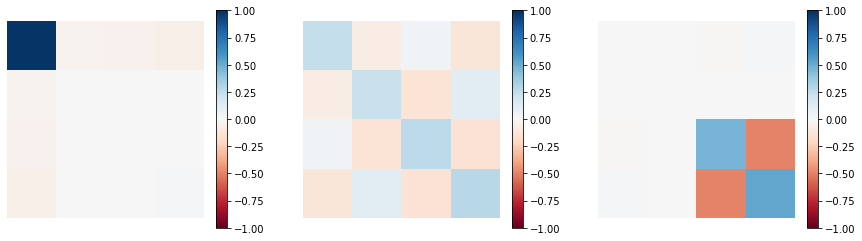

In [489]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
J, g, gx = -1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 2)
J, g, gx = -1., 2., 2.
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 3)
J, g, gx = 1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|, the first image is the one for which circuit was optimized

Compute fidelity of input and final state after it has been compressed and decompressed.

In [524]:
J, gx, gz = -1., .1, .1
gzs = np.logspace(-2, 2, 50)
fid1 = []
for gz in gzs:
    fid1.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])
    
J, gx, gz = -1., .1, .1
gxs = np.logspace(-2, 2, 50)
fid2 = []
for gx in gxs:
    fid2.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])
    
J, gx, gz = -1., .1, .1
Js = np.linspace(-10, 10, 50)
fid3 = []
for J in Js:
    fid3.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])

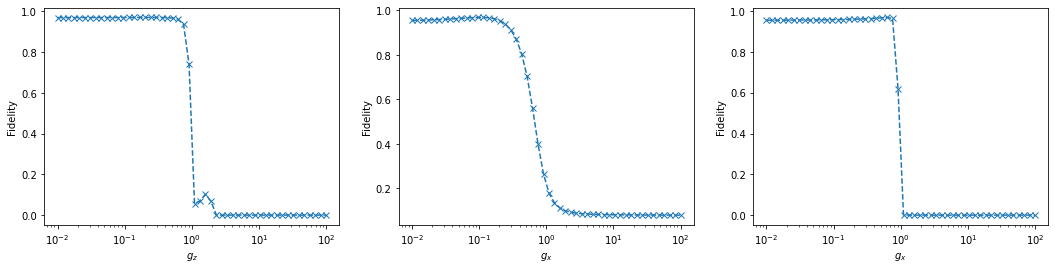

In [525]:
fig = plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(gzs, fid1, "x--")
plt.xscale("log")
plt.xlabel(r"$g_z$")
plt.ylabel("Fidelity");

plt.subplot(1, 3, 2)
plt.plot(gxs, fid2, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Fidelity");

plt.subplot(1, 3, 3)
plt.plot(gxs, fid3, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Fidelity");